# Imports

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load dataset

In [4]:


def load_images(file_path):
    with open(file_path, 'rb') as f:
        header = np.frombuffer(f.read(16), dtype=np.uint32).view(np.dtype('>u4'))  # Big-endian uint32
        magic, num_images, rows, cols = header
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        header = np.frombuffer(f.read(8), dtype=np.uint32).view(np.dtype('>u4'))  # Big-endian uint32
        magic, num_labels = header
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


# File paths
train_images_path = 'train-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'
test_images_path = 't10k-images.idx3-ubyte'
test_labels_path = 't10k-labels.idx1-ubyte'

# Load data
train_images = load_images(train_images_path)
train_labels = load_labels(train_labels_path)
test_images = load_images(test_images_path)
test_labels = load_labels(test_labels_path)

# Normalize images (MNIST normalization)
train_images = (train_images / 255.0 - 0.1307) / 0.3081
test_images = (test_images / 255.0 - 0.1307) / 0.3081

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).view(-1, 28 * 28)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).view(-1, 28 * 28) 
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

print(f"Training set: {len(train_loader)} batches")
print(f"Test set: {len(test_loader)} batches")


Training set: 937 batches
Test set: 156 batches


# Setup models

In [5]:
from neural_ode import NeuralODENetwork
from solvers import EulerSolver, RK45Solver, AdaptiveRK45Solver

## Neural ODE setup

In [7]:
INPUT_DIM = 784  # MNIST images are 28x28
NUM_CLASSES = 10  # Digits 0-9

latent_converter = nn.Sequential(
    nn.Linear(INPUT_DIM, 128),
    nn.ReLU()
) # Embedding function, it's just a function called before the dynamics function

dynamics_approximator = nn.Sequential(
    nn.Linear(128 + 1, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU()
) # Dynamics function represented as a dense neural network

classifier_head = nn.Sequential(
    nn.Linear(128, NUM_CLASSES)
) # Classification head

# Setup ODE solver
solver = AdaptiveRK45Solver(time_range=(0, 1.1), max_step_size=0.01, min_step_size=0.001, error_tolerance=1e-3, include_state_in_dynamics=True)

# Create Neural ODE using solver and dynamics function
n_ode_2 = NeuralODENetwork(latent_dynamics_function=dynamics_approximator, solver=solver)

n_ode_2.attach_pre_solver_function(latent_converter)
n_ode_2.attach_task_head(classifier_head)


## Setup training functions

In [8]:
def train_and_evaluate_mnist_model(model, train_loader, test_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, 28 * 28)  # Flatten MNIST images
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.view(-1, 28 * 28)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(
            f"Epoch [{epoch + 1}/{epochs}] "
            f"Train Loss: {train_losses[-1]:.4f}, "
            f"Test Loss: {test_losses[-1]:.4f}, "
            f"Test Accuracy: {test_accuracies[-1]:.4f}"
        )

    return train_losses, test_losses, test_accuracies

In [9]:
def plot_metrics(train_losses, test_losses, test_accuracies):
    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [10]:
def train_and_evaluate_per_step(model, train_loader, test_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Training step
            images = images.view(-1, 28 * 28)  # Flatten MNIST images
            optimizer.zero_grad()
            # print(f"Input batch size: {images.size(0)}")
            outputs = model(images)
            # print(f"Output batch size: {outputs.size(0)}")
            # print(f"Labels batch size: {labels.size(0)}")
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Log training loss
            train_losses.append(loss.item())

            # Calculate training accuracy for the batch
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            train_accuracy = correct / labels.size(0)

            print(
                f"Step {batch_idx + 1}/{len(train_loader)} - "
                f"Train Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}"
            )

            # Periodically evaluate on the test set
            if (batch_idx + 1) % 100 == 0 or batch_idx == len(train_loader) - 1:
                model.eval()
                test_loss = 0.0
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.view(-1, 28 * 28)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        test_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                test_losses.append(test_loss / len(test_loader))
                test_accuracy = correct / total
                test_accuracies.append(test_accuracy)

                print(
                    f"    Test Loss: {test_loss / len(test_loader):.4f}, "
                    f"Test Accuracy: {test_accuracy:.4f}"
                )
                model.train()  # Switch back to training mode

    return train_losses, test_losses, test_accuracies

#TRAINING LOOP FOR MNIST PER TRAIN STEP, FOR MORE INFO 

## Training the neural ODE

Epoch 1/1


c:\Users\rafal.osadnik\Code\liquid-from-scratch\solvers\rk45.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step_sizes_tensor = torch.tensor(self._step_size, dtype=torch.float).repeat(batch_size)


Timesteps:  111
Step 1/937 - Train Loss: 4.7383, Train Accuracy: 0.0938
Timesteps:  111
Step 2/937 - Train Loss: 4.5673, Train Accuracy: 0.0625
Timesteps:  111
Step 3/937 - Train Loss: 3.7597, Train Accuracy: 0.1562
Timesteps:  111
Step 4/937 - Train Loss: 4.0256, Train Accuracy: 0.1094
Timesteps:  111
Step 5/937 - Train Loss: 4.0893, Train Accuracy: 0.1094
Timesteps:  111
Step 6/937 - Train Loss: 3.7489, Train Accuracy: 0.1406
Timesteps:  111
Step 7/937 - Train Loss: 3.6886, Train Accuracy: 0.0625
Timesteps:  111
Step 8/937 - Train Loss: 3.0599, Train Accuracy: 0.2188
Timesteps:  111
Step 9/937 - Train Loss: 3.4045, Train Accuracy: 0.1250
Timesteps:  111
Step 10/937 - Train Loss: 3.1526, Train Accuracy: 0.2656
Timesteps:  111
Step 11/937 - Train Loss: 2.8661, Train Accuracy: 0.1562
Timesteps:  111
Step 12/937 - Train Loss: 3.0217, Train Accuracy: 0.1719
Timesteps:  111
Step 13/937 - Train Loss: 3.1345, Train Accuracy: 0.1094
Timesteps:  111
Step 14/937 - Train Loss: 2.8603, Train Accu

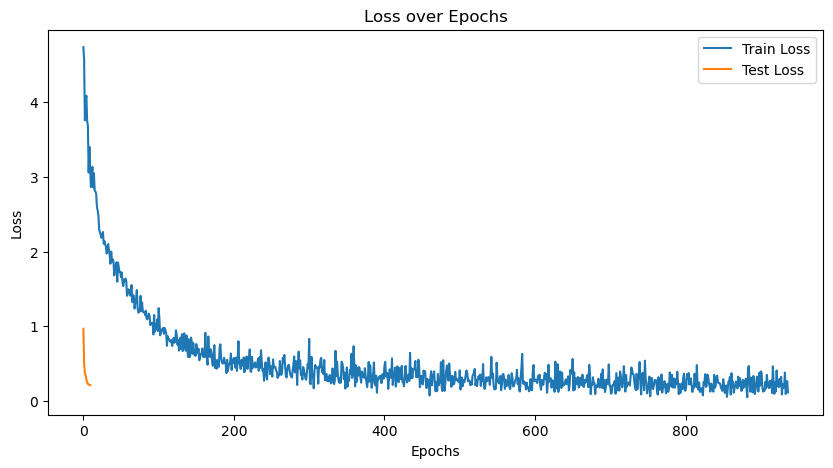

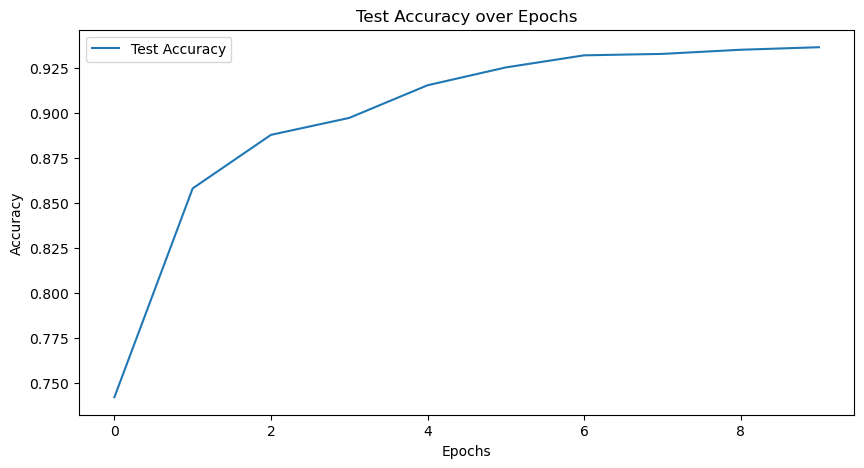

In [19]:
# Train the model and collect metrics
epochs = 1
train_losses_2, test_losses_2, test_accuracies_2 = train_and_evaluate_per_step(
    n_ode_2, train_loader, test_loader, epochs
)

# Visualize the metrics
plot_metrics(train_losses_2, test_losses_2, test_accuracies_2)

In [20]:
print("Neural ODE parameter count:", sum(p.numel() for p in n_ode.parameters()))

Neural ODE parameter count: 122602


## Setup a simple MLP

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # Similar structure as dynamics_approximator
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Output layer for classification
        )

    def forward(self, x):
        return self.net(x)

## Training the MLP

In [22]:
mlp_model = SimpleMLP()
train_losses_mlp, test_losses_mlp, test_accuracies_mlp = train_and_evaluate_per_step(
    mlp_model, train_loader, test_loader, epochs=1
)


Epoch 1/1
Step 1/937 - Train Loss: 2.3043, Train Accuracy: 0.1250
Step 2/937 - Train Loss: 2.3016, Train Accuracy: 0.1094
Step 3/937 - Train Loss: 2.3020, Train Accuracy: 0.0781
Step 4/937 - Train Loss: 2.3191, Train Accuracy: 0.0625
Step 5/937 - Train Loss: 2.3010, Train Accuracy: 0.1094
Step 6/937 - Train Loss: 2.3165, Train Accuracy: 0.1250
Step 7/937 - Train Loss: 2.2841, Train Accuracy: 0.1406
Step 8/937 - Train Loss: 2.2934, Train Accuracy: 0.0625
Step 9/937 - Train Loss: 2.2929, Train Accuracy: 0.1406
Step 10/937 - Train Loss: 2.2814, Train Accuracy: 0.0938
Step 11/937 - Train Loss: 2.3082, Train Accuracy: 0.1250
Step 12/937 - Train Loss: 2.3058, Train Accuracy: 0.0469
Step 13/937 - Train Loss: 2.3091, Train Accuracy: 0.0156
Step 14/937 - Train Loss: 2.2986, Train Accuracy: 0.0781
Step 15/937 - Train Loss: 2.2978, Train Accuracy: 0.0625
Step 16/937 - Train Loss: 2.2939, Train Accuracy: 0.2031
Step 17/937 - Train Loss: 2.3043, Train Accuracy: 0.1250
Step 18/937 - Train Loss: 2.30

In [23]:
print("MLP model parameter count:", sum(p.numel() for p in mlp_model.parameters()))	

MLP model parameter count: 290218


## Training comparison

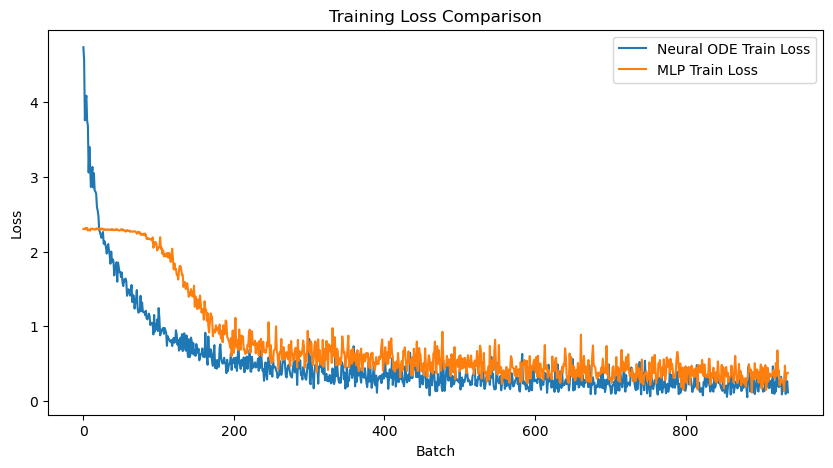

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_2, label="Neural ODE Train Loss")
plt.plot(train_losses_mlp, label="MLP Train Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

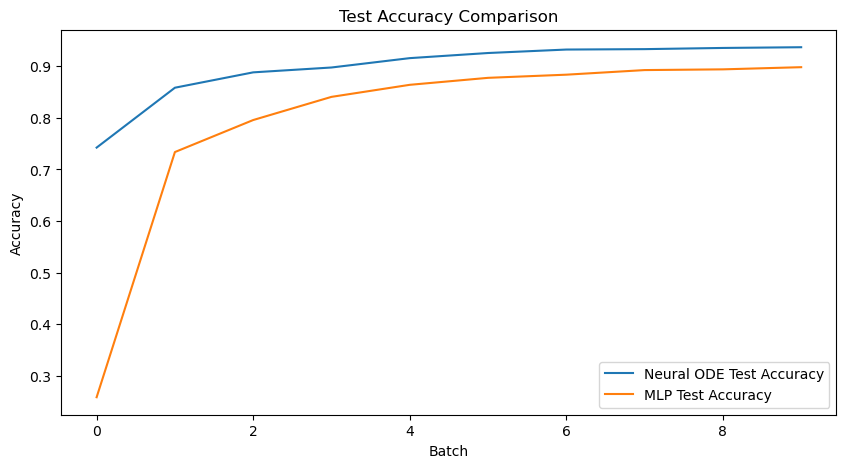

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies_2, label="Neural ODE Test Accuracy")
plt.plot(test_accuracies_mlp, label="MLP Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Hidden state analysis

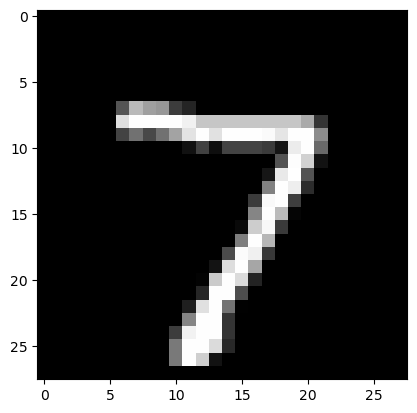

In [28]:
sample = next(iter(test_loader))
image = sample[0][0].reshape(28, 28)
plt.imshow(image, cmap='gray')

In [29]:
hidden_states_mlp = []
x = sample[0][0].view(-1)
for layer_mlp in mlp_model.net:
    x = layer_mlp(x)
    if isinstance(layer_mlp, nn.Linear):
        hidden_states_mlp.append(x)

hidden_states_mlp = hidden_states_mlp[:-1]
longest_hidden_state_mlp = max(hidden_states_mlp, key=len)
hidden_states_mlp_padded = [F.pad(h, (0, len(longest_hidden_state_mlp) - len(h))).unsqueeze(dim=0) for h in hidden_states_mlp]

hidden_states_mlp_tensor = torch.concatenate(hidden_states_mlp_padded, dim=0).detach().numpy()

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
hidden_states_mlp_pca = pca.fit_transform(hidden_states_mlp_tensor)

Text(0, 0.5, 'PC2')

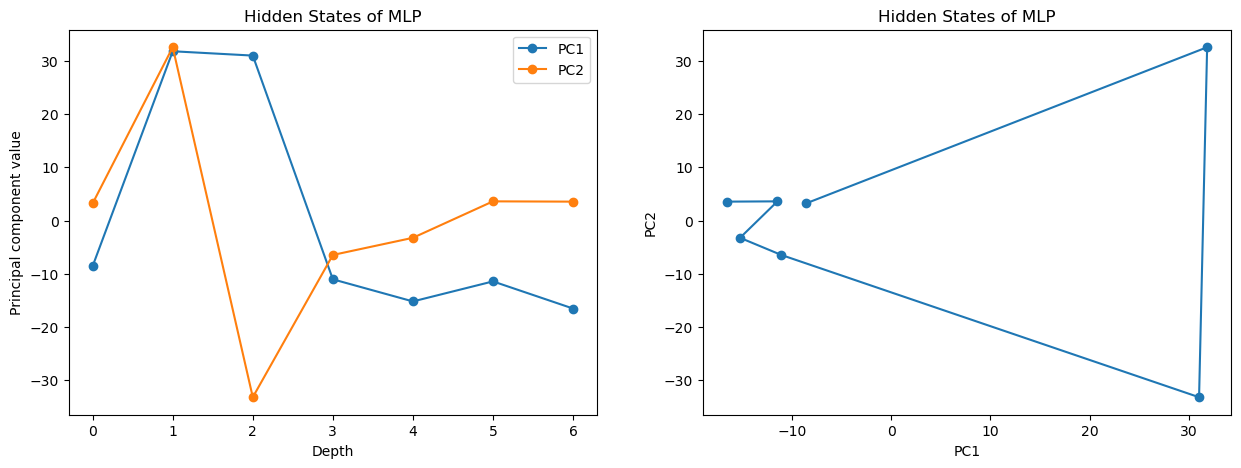

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hidden_states_mlp_pca[:, 0], marker='o')
plt.plot(hidden_states_mlp_pca[:, 1], marker='o')
plt.title("Hidden States of MLP")
plt.xlabel("Depth")
plt.ylabel("Principal component value")
plt.legend(["PC1", "PC2"])

plt.subplot(1, 2, 2)
plt.plot(hidden_states_mlp_pca[:, 0], hidden_states_mlp_pca[:, 1], marker='o')
plt.title("Hidden States of MLP")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [33]:
hidden_states_node = []
x = sample[0][0].view(-1)

hidden_states_node = n_ode_2.forward_hidden_states(x.unsqueeze(dim=0)).detach()

c:\Users\rafal.osadnik\Code\liquid-from-scratch\solvers\rk45.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step_sizes_tensor = torch.tensor(self._step_size, dtype=torch.float).repeat(batch_size)


In [34]:
pca = PCA(n_components=2)
hidden_states_node_pca = pca.fit_transform(hidden_states_node.squeeze(0))

Text(0, 0.5, 'PC2')

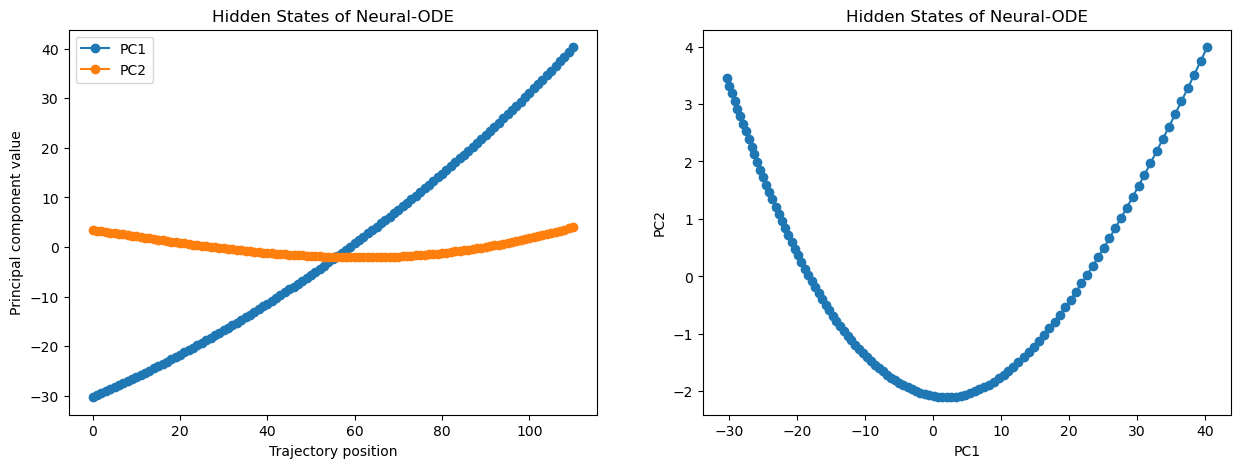

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hidden_states_node_pca[:, 0], marker='o')
plt.plot(hidden_states_node_pca[:, 1], marker='o')
plt.title("Hidden States of Neural-ODE")
plt.xlabel("Trajectory position")
plt.ylabel("Principal component value")
plt.legend(["PC1", "PC2"])

plt.subplot(1, 2, 2)
plt.plot(hidden_states_node_pca[:, 0], hidden_states_node_pca[:, 1], marker='o')
plt.title("Hidden States of Neural-ODE")
plt.xlabel("PC1")
plt.ylabel("PC2")